## **Demo Notebook**

This quick notebook will show how to

* load config
* create the dataset
* make a model
* load pretrained weights

This notebook should be run directly from the `scripts/` directory.

### **Config**

Make sure to change the following paths
* `DATASET_DIR`
* `LABELS_DIR`

In [ ]:
from hydra import core, initialize, compose
from omegaconf import OmegaConf

import sys
sys.path.append("/data/zhulianghui/ProjectB_BEV/cross_view_transformers")


# CHANGE ME
DATASET_DIR = '/data/datasets/nuscenes'
LABELS_DIR = '/data/datasets/cvt_gen_test'


core.global_hydra.GlobalHydra.instance().clear()        # required for Hydra in notebooks

initialize(config_path='../config')

# Add additional command line overrides
cfg = compose(
    config_name='config',
    overrides=[
        'experiment.save_dir=../logs/',                 # required for Hydra in notebooks
        '+experiment=cvt_nuscenes_vehicle',
        f'data.dataset_dir={DATASET_DIR}',
        f'data.labels_dir={LABELS_DIR}',
        'data.version=v1.0-trainval',
        'loader.batch_size=1',
    ]
)

# resolve config references
OmegaConf.resolve(cfg)

print(list(cfg.keys()))
print(cfg['visualization'])

### **Dataset Setup**

In [ ]:
import torch
import numpy as np

from cross_view_transformer.common import setup_experiment, load_backbone


# Additional splits can be added to cross_view_transformer/data/splits/nuscenes/
SPLIT = 'val_qualitative_000'
SUBSAMPLE = 5


model, data, viz = setup_experiment(cfg)

dataset = data.get_split(SPLIT, loader=False)
dataset = torch.utils.data.ConcatDataset(dataset)
dataset = torch.utils.data.Subset(dataset, range(0, len(dataset), SUBSAMPLE))

loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=2)

print(len(dataset))

### **Network Setup**

In [ ]:
from pathlib import Path


# Download a pretrained model (13 Mb)
# MODEL_URL = 'https://www.cs.utexas.edu/~bzhou/cvt/cvt_nuscenes_vehicles_50k.ckpt'
# CHECKPOINT_PATH = '../logs/cvt_nuscenes_vehicles_50k.ckpt'
# CHECKPOINT_PATH = '/data/zhulianghui/ProjectB_BEV/cross_view_transformers/logs/cross_view_transformers_test/version_16/checkpoints/model-v1.ckpt'
CHECKPOINT_PATH = '/data/zhulianghui/ProjectX_Transformer/cross_view_transformers+/logs/cross_view_transformers_test_ori/version_1/checkpoints/model-v1.ckpt'
CHECKPOINT_PATH = '/data/zhulianghui/ProjectB_BEV/cross_view_transformers/logs/cross_view_transformers_test/version_24/checkpoints/model-v1.ckpt'
# !wget $MODEL_URL -O $CHECKPOINT_PATH


if Path(CHECKPOINT_PATH).exists():
    network = load_backbone(CHECKPOINT_PATH)
else:
    network = model.backbone

    print(f'{CHECKPOINT_PATH} not found. Using randomly initialized weights.')

### **Run the Model**

This cell will save the model predictions and render them as a gif.

Note: colors will be ugly since gif only supports 256 colors total

In [ ]:
import torch
import time
import imageio
import ipywidgets as widgets


GIF_PATH = './predictions.gif'

print("decide device...")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

network.to(device)
network.eval()

images = list()

print("loader len is : ", len(loader))



# test all

In [ ]:
with torch.no_grad():
    for batch in loader:
        batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
        pred = network(batch)

        visualization = np.vstack(viz(batch=batch, pred=pred))

        images.append(visualization)
        
        break

# test instance displace

In [ ]:
from cross_view_transformer.utils.instance import predict_instance_segmentation_and_trajectories

def colorize_displacement(disp, if_scale=False):

    if if_scale:
        pos = np.where(disp < 254)
        disp[pos] = disp[pos] * 5 * 2


    import matplotlib.colors
    import math

    a = (np.arctan2(-disp[0], -disp[1]) / math.pi + 1) / 2

    r = np.sqrt(disp[0] ** 2 + disp[1] ** 2)
    s = r / np.max(r)
    hsv_color = np.stack((a, s, np.ones_like(a)), axis=-1)
    rgb_color = matplotlib.colors.hsv_to_rgb(hsv_color)

    import matplotlib.pylab as plt
    plt.imshow(rgb_color)
    plt.show()

    return rgb_color

jump_flag = 1

import matplotlib
with torch.no_grad():
    for batch in loader:
        
        jump_flag -= 1
        if jump_flag != 0:
            continue
        
        batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
        # batch keys
        print('batch keys: ', batch.keys())
        print('center shape: ', batch['center'].shape)
        print('instance shape: ', batch['instance_bev'].shape)
        print('instance unique: ', torch.unique(batch['instance_bev']))
        import matplotlib.pylab as plt
        plt.imshow(batch['instance_bev'][0, 0, :, :].cpu())
        plt.show()
        print('disp shape: ', batch['offset_bev'].shape)
        
        
        disp = batch['offset_bev'].squeeze(0).cpu().numpy()
        print('disp shape: ', disp.shape)
        
        disp_color = colorize_displacement(disp, if_scale=True)
        
#         matplotlib.pyplot.figure(figsize=(90, 25))
#         matplotlib.pyplot.imshow(pred['center'].squeeze(0).squeeze(0).cpu())
#         matplotlib.pyplot.show()
#         matplotlib.pyplot.imshow(pred_consistent_instance_seg.squeeze(0).squeeze(0).cpu())
#         matplotlib.pyplot.show()
        
        break

# end the debug
# import sys; sys.exit()

# test center process

In [ ]:
from cross_view_transformer.utils.instance import predict_instance_segmentation_and_trajectories

jump_flag = 1

import matplotlib
with torch.no_grad():
    for batch in loader:
        jump_flag -= 1
        if jump_flag != 0:
            continue
        batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
        
        # batch keys
        print('batch keys: ', batch.keys())
        
        pred = network(batch)
        
        # center scale
        
        # version: 1
        # pos = torch.where(pred['center'] > 0)
        # pred['center'][pos] *= 10
        # print("postive center: ", pred['center'][pos].unique())
        
        # version: 2
        pred['center'] = torch.sigmoid(pred['center'])
        
        # version: 3
#         pred['center'] = batch['center']
        
        
        # for center process preprocess
        n, c, h, w = pred['bev'].shape
        
        ground_truth = batch['bev'][:, 4:8,:,:].sum(1, keepdim=False)
        
        print('ground_truth shape: ', ground_truth.shape)
        print(ground_truth)
        
#         pred['segmentation'] = ground_truth.unsqueeze(1).cpu() * 0.6
#         pred['segmentation'] = pred['bev'].unsqueeze(1).cpu()
        # sigmoid bev version
        pred['segmentation'] = torch.sigmoid(pred['bev'].unsqueeze(1).cpu())

        print('pred shape: ', pred['segmentation'].shape)
        pred['instance_center'] = pred['center'].unsqueeze(1).cpu()
        # pred['instance_offset'] = torch.zeros([n, 1, 2, h, w])
        pred['instance_offset'] = batch['offset_bev'].unsqueeze(0).cpu()
        
        print('center shape: ', pred['center'].shape)
        print('center unique: ', pred['center'].unique)
        print(pred['instance_offset'].shape)
        
        
        pred['instance_flow'] = None
        thresh = 0.4 * torch.ones_like(pred['segmentation'], device=pred['segmentation'].device)
        pred['segmentation'] = torch.cat((thresh, pred['segmentation']), 2)
        # center generation
        pred_consistent_instance_seg = predict_instance_segmentation_and_trajectories(
                pred, compute_matched_centers=False, make_consistent=True
            )
        
        print('instance seg len: ', len(pred_consistent_instance_seg))
#         import sys; sys.exit()
        print('instance seg shape: ', pred_consistent_instance_seg.shape)
        
        ins_np = pred_consistent_instance_seg.numpy()
        print('ins np unique: ', np.unique(ins_np))
        
#         pos = np.where(ins_np != 0)
#         print('ins np non-zero location: ', pos)
        
        # contents in pred
        print(pred.keys())
        print(pred['bev'].shape)

        visualization = np.vstack(viz(batch=batch, pred=pred))
        
        # show details of pred['center']
        # visualization = pred['center'].cpu()

        # print origin gt
        # visualization = np.vstack(viz(batch=batch))

        images.append(visualization)
        
        # get cropped shape
        visualization = visualization[:, -200:, :]
        print(visualization.shape)
        
        # get np version
        v_np = visualization
        print('max: ', v_np.max())
        print('min: ', v_np.min())
        print('unique: ', np.unique(v_np))
        

        matplotlib.pyplot.figure(figsize=(90, 25))
#         matplotlib.pyplot.imshow(visualization)
        matplotlib.pyplot.imshow(pred['center'].squeeze(0).squeeze(0).cpu())
        matplotlib.pyplot.show()
        matplotlib.pyplot.imshow(pred_consistent_instance_seg.squeeze(0).squeeze(0).cpu())
        matplotlib.pyplot.show()
        
        # test metric
#         !pip list
#         from pytorch_lightning.metrics.metric import Metric
#         from torchmetrics import Metric
#         from torchmetrics.classification import stat_scores_multiple_classes
#         from pytorch_lightning.metrics.functional.reduction import reduce

        # test video format input
#         pred_consistent_instance_seg = pred_consistent_instance_seg.unsqueeze(0)
#         batch['instance_bev'] = batch['instance_bev'].unsqueeze(0)

        from cross_view_transformer.metrics import PanopticMetric
        metric_panoptic_val = PanopticMetric(n_classes=2)
        print("instance bev pred shape: ", pred_consistent_instance_seg.shape)
        print("instance bev pred type: ", pred_consistent_instance_seg.dtype)
        print("instance bev gt shape:", batch['instance_bev'].shape)
        print("instance bev gt type: ", batch['instance_bev'].dtype)
        
        print("instance_bev_unique before turn: ", torch.unique(batch['instance_bev']))
#         batch['instance_bev'] = batch['instance_bev'].type_as(pred_consistent_instance_seg)
        print("instance_bev_unique after turn: ", torch.unique(batch['instance_bev']))
        
        # save result for test
        import numpy as np
        np.save('./pred.npy', pred_consistent_instance_seg.cpu().numpy())
        np.save('./gt.npy', batch['instance_bev'].cpu().numpy())
        
        # instance gt process
        ins_gt = batch['instance_bev']
        ins_gt_unique = torch.unique(batch['instance_bev'])
        ins_gt_int = torch.zeros_like(batch['instance_bev'], dtype=torch.int64)
        for i in range(len(ins_gt_unique)):
            pos = torch.where(ins_gt == ins_gt_unique[i])
            ins_gt_int[pos] = i
        
        print('ins_gt_int unique: ', torch.unique(ins_gt_int))
        metric_panoptic_val(pred_consistent_instance_seg.cpu(), ins_gt_int.cpu())
        # gt test
#         metric_panoptic_val(ins_gt_int.cpu(), ins_gt_int.cpu())    
    
        scores = metric_panoptic_val.compute()
        print("instance scores: ", scores)
        
#         print("instance metric res: ", res)
        
        print("instance metric iou: ", metric_panoptic_val.iou)
        
        break

# end the debug
import sys; sys.exit()

# test my visualize

In [ ]:
import matplotlib
with torch.no_grad():
    for batch in loader:
        batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
        pred = network(batch)
        
        # contents in pred
        print(pred.keys())
        print(pred['bev'].shape)

        visualization = np.vstack(viz(batch=batch, pred=pred))

        # print origin gt
        # visualization = np.vstack(viz(batch=batch))

        images.append(visualization)
        
        # get cropped shape
        visualization = visualization[:, -200:, :]
        print(visualization.shape)
        
        # get np version
        v_np = visualization
        print('max: ', v_np.max())
        print('min: ', v_np.min())
        print('unique: ', np.unique(v_np))
        

        matplotlib.pyplot.figure(figsize=(90, 25))
        matplotlib.pyplot.imshow(visualization)
        matplotlib.pyplot.imshow(pred['center'].squeeze(0).squeeze(0).cpu())
        matplotlib.pyplot.show()
        
        break


# Origin Gif Generation

In [ ]:

with torch.no_grad():
    for batch in loader:
        batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
        pred = network(batch)

        visualization = np.vstack(viz(batch=batch, pred=pred))

        images.append(visualization)
        
        break


print("ready to save...")
# Save a gif
duration = [1 for _ in images[:-1]] + [5 for _ in images[-1:]]
imageio.mimsave(GIF_PATH, images, duration=duration)

html = f'''
<div align="center">
<img src="{GIF_PATH}?modified={time.time()}" width="80%">
</div>
'''

display(widgets.HTML(html))

# BEV 问题 08.15
* center中点不为1
* 没有instance seg 的标注
* 没有instance bbox 的标注

# cvt instance seg baseline
* step1：prediction
    * 语义分割
    * 中心点分割
    * offset回归
* step2：post process
    * center point threshold & maxpooling
    * group center location & assign

# test all

In [ ]:
with torch.no_grad():
    for batch in loader:
        batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
        pred = network(batch)

        visualization = np.vstack(viz(batch=batch, pred=pred))

        images.append(visualization)
        
        break

# test instance dispalace

In [ ]:
from cross_view_transformer.utils.instance import predict_instance_segmentation_and_trajectories

def colorize_displacement(disp, if_scale=False):

    if if_scale:
        pos = np.where(disp < 254)
        disp[pos] = disp[pos] * 5 * 2


    import matplotlib.colors
    import math

    a = (np.arctan2(-disp[0], -disp[1]) / math.pi + 1) / 2

    r = np.sqrt(disp[0] ** 2 + disp[1] ** 2)
    s = r / np.max(r)
    hsv_color = np.stack((a, s, np.ones_like(a)), axis=-1)
    rgb_color = matplotlib.colors.hsv_to_rgb(hsv_color)

    import matplotlib.pylab as plt
    plt.imshow(rgb_color)
    plt.show()

    return rgb_color

jump_flag = 1

import matplotlib
with torch.no_grad():
    for batch in loader:
        
        jump_flag -= 1
        if jump_flag != 0:
            continue
        
        batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
        # batch keys
        print('batch keys: ', batch.keys())
        print('center shape: ', batch['center'].shape)
        print('instance shape: ', batch['instance_bev'].shape)
        print('instance unique: ', torch.unique(batch['instance_bev']))
        import matplotlib.pylab as plt
        plt.imshow(batch['instance_bev'][0, 0, :, :].cpu())
        plt.show()
        print('disp shape: ', batch['offset_bev'].shape)
        
        
        disp = batch['offset_bev'].squeeze(0).cpu().numpy()
        print('disp shape: ', disp.shape)
        
        disp_color = colorize_displacement(disp, if_scale=True)
        
#         matplotlib.pyplot.figure(figsize=(90, 25))
#         matplotlib.pyplot.imshow(pred['center'].squeeze(0).squeeze(0).cpu())
#         matplotlib.pyplot.show()
#         matplotlib.pyplot.imshow(pred_consistent_instance_seg.squeeze(0).squeeze(0).cpu())
#         matplotlib.pyplot.show()
        
        break

# end the debug
# import sys; sys.exit()

# test center process

In [ ]:
from cross_view_transformer.utils.instance import predict_instance_segmentation_and_trajectories

jump_flag = 1

import matplotlib
with torch.no_grad():
    for batch in loader:
        jump_flag -= 1
        if jump_flag != 0:
            continue
        batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
        
        # batch keys
        print('batch keys: ', batch.keys())
        
        pred = network(batch)
        
        # center scale
        
        # version: 1
        # pos = torch.where(pred['center'] > 0)
        # pred['center'][pos] *= 10
        # print("postive center: ", pred['center'][pos].unique())
        
        # version: 2
        pred['center'] = torch.sigmoid(pred['center'])
        
        # version: 3
#         pred['center'] = batch['center']
        
        
        # for center process preprocess
        n, c, h, w = pred['bev'].shape
        
        ground_truth = batch['bev'][:, 4:8,:,:].sum(1, keepdim=False)
        
        print('ground_truth shape: ', ground_truth.shape)
        print(ground_truth)
        
#         pred['segmentation'] = ground_truth.unsqueeze(1).cpu() * 0.6
#         pred['segmentation'] = pred['bev'].unsqueeze(1).cpu()
        # sigmoid bev version
        pred['segmentation'] = torch.sigmoid(pred['bev'].unsqueeze(1).cpu())

        print('pred shape: ', pred['segmentation'].shape)
        pred['instance_center'] = pred['center'].unsqueeze(1).cpu()
        # pred['instance_offset'] = torch.zeros([n, 1, 2, h, w])
        pred['instance_offset'] = batch['offset_bev'].unsqueeze(0).cpu()
        
        print('center shape: ', pred['center'].shape)
        print('center unique: ', pred['center'].unique)
        print(pred['instance_offset'].shape)
        
        
        pred['instance_flow'] = None
        thresh = 0.4 * torch.ones_like(pred['segmentation'], device=pred['segmentation'].device)
        pred['segmentation'] = torch.cat((thresh, pred['segmentation']), 2)
        # center generation
        pred_consistent_instance_seg = predict_instance_segmentation_and_trajectories(
                pred, compute_matched_centers=False, make_consistent=True
            )
        
        print('instance seg len: ', len(pred_consistent_instance_seg))
#         import sys; sys.exit()
        print('instance seg shape: ', pred_consistent_instance_seg.shape)
        
        ins_np = pred_consistent_instance_seg.numpy()
        print('ins np unique: ', np.unique(ins_np))
        
#         pos = np.where(ins_np != 0)
#         print('ins np non-zero location: ', pos)
        
        # contents in pred
        print(pred.keys())
        print(pred['bev'].shape)

        visualization = np.vstack(viz(batch=batch, pred=pred))
        
        # show details of pred['center']
        # visualization = pred['center'].cpu()

        # print origin gt
        # visualization = np.vstack(viz(batch=batch))

        images.append(visualization)
        
        # get cropped shape
        visualization = visualization[:, -200:, :]
        print(visualization.shape)
        
        # get np version
        v_np = visualization
        print('max: ', v_np.max())
        print('min: ', v_np.min())
        print('unique: ', np.unique(v_np))
        

        matplotlib.pyplot.figure(figsize=(90, 25))
#         matplotlib.pyplot.imshow(visualization)
        matplotlib.pyplot.imshow(pred['center'].squeeze(0).squeeze(0).cpu())
        matplotlib.pyplot.show()
        matplotlib.pyplot.imshow(pred_consistent_instance_seg.squeeze(0).squeeze(0).cpu())
        matplotlib.pyplot.show()
        
        # test metric
#         !pip list
#         from pytorch_lightning.metrics.metric import Metric
#         from torchmetrics import Metric
#         from torchmetrics.classification import stat_scores_multiple_classes
#         from pytorch_lightning.metrics.functional.reduction import reduce

        # test video format input
#         pred_consistent_instance_seg = pred_consistent_instance_seg.unsqueeze(0)
#         batch['instance_bev'] = batch['instance_bev'].unsqueeze(0)

        from cross_view_transformer.metrics import PanopticMetric
        metric_panoptic_val = PanopticMetric(n_classes=2)
        print("instance bev pred shape: ", pred_consistent_instance_seg.shape)
        print("instance bev pred type: ", pred_consistent_instance_seg.dtype)
        print("instance bev gt shape:", batch['instance_bev'].shape)
        print("instance bev gt type: ", batch['instance_bev'].dtype)
        
        print("instance_bev_unique before turn: ", torch.unique(batch['instance_bev']))
#         batch['instance_bev'] = batch['instance_bev'].type_as(pred_consistent_instance_seg)
        print("instance_bev_unique after turn: ", torch.unique(batch['instance_bev']))
        
        # save result for test
        import numpy as np
        np.save('./pred.npy', pred_consistent_instance_seg.cpu().numpy())
        np.save('./gt.npy', batch['instance_bev'].cpu().numpy())
        
        # instance gt process
        ins_gt = batch['instance_bev']
        ins_gt_unique = torch.unique(batch['instance_bev'])
        ins_gt_int = torch.zeros_like(batch['instance_bev'], dtype=torch.int64)
        for i in range(len(ins_gt_unique)):
            pos = torch.where(ins_gt == ins_gt_unique[i])
            ins_gt_int[pos] = i
        
        print('ins_gt_int unique: ', torch.unique(ins_gt_int))
        metric_panoptic_val(pred_consistent_instance_seg.cpu(), ins_gt_int.cpu())
        # gt test
#         metric_panoptic_val(ins_gt_int.cpu(), ins_gt_int.cpu())    
    
        scores = metric_panoptic_val.compute()
        print("instance scores: ", scores)
        
#         print("instance metric res: ", res)
        
        print("instance metric iou: ", metric_panoptic_val.iou)
        
        break

# end the debug
import sys; sys.exit()

# test my visualize

In [ ]:
import matplotlib
with torch.no_grad():
    for batch in loader:
        batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
        pred = network(batch)
        
        # contents in pred
        print(pred.keys())
        print(pred['bev'].shape)

        visualization = np.vstack(viz(batch=batch, pred=pred))

        # print origin gt
        # visualization = np.vstack(viz(batch=batch))

        images.append(visualization)
        
        # get cropped shape
        visualization = visualization[:, -200:, :]
        print(visualization.shape)
        
        # get np version
        v_np = visualization
        print('max: ', v_np.max())
        print('min: ', v_np.min())
        print('unique: ', np.unique(v_np))
        

        matplotlib.pyplot.figure(figsize=(90, 25))
        matplotlib.pyplot.imshow(visualization)
        matplotlib.pyplot.imshow(pred['center'].squeeze(0).squeeze(0).cpu())
        matplotlib.pyplot.show()
        
        break


# Origin Gif Generation

In [ ]:

with torch.no_grad():
    for batch in loader:
        batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
        pred = network(batch)

        visualization = np.vstack(viz(batch=batch, pred=pred))

        images.append(visualization)
        
        break


print("ready to save...")
# Save a gif
duration = [1 for _ in images[:-1]] + [5 for _ in images[-1:]]
imageio.mimsave(GIF_PATH, images, duration=duration)

html = f'''
<div align="center">
<img src="{GIF_PATH}?modified={time.time()}" width="80%">
</div>
'''

display(widgets.HTML(html))

# BEV 问题 08.15
* center中点不为1
* 没有instance seg 的标注
* 没有instance bbox 的标注

# cvt instance seg baseline
* step1：prediction
    * 语义分割
    * 中心点分割
    * offset回归
* step2：post process
    * center point threshold & maxpooling
    * group center location & assign

# test all

In [ ]:
with torch.no_grad():
    for batch in loader:
        batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
        pred = network(batch)

        visualization = np.vstack(viz(batch=batch, pred=pred))

        images.append(visualization)
        
        break

# test instance dispalace

In [ ]:
from cross_view_transformer.utils.instance import predict_instance_segmentation_and_trajectories

def colorize_displacement(disp, if_scale=False):

    if if_scale:
        pos = np.where(disp < 254)
        disp[pos] = disp[pos] * 5 * 2


    import matplotlib.colors
    import math

    a = (np.arctan2(-disp[0], -disp[1]) / math.pi + 1) / 2

    r = np.sqrt(disp[0] ** 2 + disp[1] ** 2)
    s = r / np.max(r)
    hsv_color = np.stack((a, s, np.ones_like(a)), axis=-1)
    rgb_color = matplotlib.colors.hsv_to_rgb(hsv_color)

    import matplotlib.pylab as plt
    plt.imshow(rgb_color)
    plt.show()

    return rgb_color

jump_flag = 1

import matplotlib
with torch.no_grad():
    for batch in loader:
        
        jump_flag -= 1
        if jump_flag != 0:
            continue
        
        batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
        # batch keys
        print('batch keys: ', batch.keys())
        print('center shape: ', batch['center'].shape)
        print('instance shape: ', batch['instance_bev'].shape)
        print('instance unique: ', torch.unique(batch['instance_bev']))
        import matplotlib.pylab as plt
        plt.imshow(batch['instance_bev'][0, 0, :, :].cpu())
        plt.show()
        print('disp shape: ', batch['offset_bev'].shape)
        
        
        disp = batch['offset_bev'].squeeze(0).cpu().numpy()
        print('disp shape: ', disp.shape)
        
        disp_color = colorize_displacement(disp, if_scale=True)
        
#         matplotlib.pyplot.figure(figsize=(90, 25))
#         matplotlib.pyplot.imshow(pred['center'].squeeze(0).squeeze(0).cpu())
#         matplotlib.pyplot.show()
#         matplotlib.pyplot.imshow(pred_consistent_instance_seg.squeeze(0).squeeze(0).cpu())
#         matplotlib.pyplot.show()
        
        break

# end the debug
# import sys; sys.exit()

# test center process

In [ ]:
from cross_view_transformer.utils.instance import predict_instance_segmentation_and_trajectories

jump_flag = 1

import matplotlib
with torch.no_grad():
    for batch in loader:
        jump_flag -= 1
        if jump_flag != 0:
            continue
        batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
        
        # batch keys
        print('batch keys: ', batch.keys())
        
        pred = network(batch)
        
        # center scale
        
        # version: 1
        # pos = torch.where(pred['center'] > 0)
        # pred['center'][pos] *= 10
        # print("postive center: ", pred['center'][pos].unique())
        
        # version: 2
        pred['center'] = torch.sigmoid(pred['center'])
        
        # version: 3
#         pred['center'] = batch['center']
        
        
        # for center process preprocess
        n, c, h, w = pred['bev'].shape
        
        ground_truth = batch['bev'][:, 4:8,:,:].sum(1, keepdim=False)
        
        print('ground_truth shape: ', ground_truth.shape)
        print(ground_truth)
        
#         pred['segmentation'] = ground_truth.unsqueeze(1).cpu() * 0.6
#         pred['segmentation'] = pred['bev'].unsqueeze(1).cpu()
        # sigmoid bev version
        pred['segmentation'] = torch.sigmoid(pred['bev'].unsqueeze(1).cpu())

        print('pred shape: ', pred['segmentation'].shape)
        pred['instance_center'] = pred['center'].unsqueeze(1).cpu()
        # pred['instance_offset'] = torch.zeros([n, 1, 2, h, w])
        pred['instance_offset'] = batch['offset_bev'].unsqueeze(0).cpu()
        
        print('center shape: ', pred['center'].shape)
        print('center unique: ', pred['center'].unique)
        print(pred['instance_offset'].shape)
        
        
        pred['instance_flow'] = None
        thresh = 0.4 * torch.ones_like(pred['segmentation'], device=pred['segmentation'].device)
        pred['segmentation'] = torch.cat((thresh, pred['segmentation']), 2)
        # center generation
        pred_consistent_instance_seg = predict_instance_segmentation_and_trajectories(
                pred, compute_matched_centers=False, make_consistent=True
            )
        
        print('instance seg len: ', len(pred_consistent_instance_seg))
#         import sys; sys.exit()
        print('instance seg shape: ', pred_consistent_instance_seg.shape)
        
        ins_np = pred_consistent_instance_seg.numpy()
        print('ins np unique: ', np.unique(ins_np))
        
#         pos = np.where(ins_np != 0)
#         print('ins np non-zero location: ', pos)
        
        # contents in pred
        print(pred.keys())
        print(pred['bev'].shape)

        visualization = np.vstack(viz(batch=batch, pred=pred))
        
        # show details of pred['center']
        # visualization = pred['center'].cpu()

        # print origin gt
        # visualization = np.vstack(viz(batch=batch))

        images.append(visualization)
        
        # get cropped shape
        visualization = visualization[:, -200:, :]
        print(visualization.shape)
        
        # get np version
        v_np = visualization
        print('max: ', v_np.max())
        print('min: ', v_np.min())
        print('unique: ', np.unique(v_np))
        

        matplotlib.pyplot.figure(figsize=(90, 25))
#         matplotlib.pyplot.imshow(visualization)
        matplotlib.pyplot.imshow(pred['center'].squeeze(0).squeeze(0).cpu())
        matplotlib.pyplot.show()
        matplotlib.pyplot.imshow(pred_consistent_instance_seg.squeeze(0).squeeze(0).cpu())
        matplotlib.pyplot.show()
        
        # test metric
#         !pip list
#         from pytorch_lightning.metrics.metric import Metric
#         from torchmetrics import Metric
#         from torchmetrics.classification import stat_scores_multiple_classes
#         from pytorch_lightning.metrics.functional.reduction import reduce

        # test video format input
#         pred_consistent_instance_seg = pred_consistent_instance_seg.unsqueeze(0)
#         batch['instance_bev'] = batch['instance_bev'].unsqueeze(0)

        from cross_view_transformer.metrics import PanopticMetric
        metric_panoptic_val = PanopticMetric(n_classes=2)
        print("instance bev pred shape: ", pred_consistent_instance_seg.shape)
        print("instance bev pred type: ", pred_consistent_instance_seg.dtype)
        print("instance bev gt shape:", batch['instance_bev'].shape)
        print("instance bev gt type: ", batch['instance_bev'].dtype)
        
        print("instance_bev_unique before turn: ", torch.unique(batch['instance_bev']))
#         batch['instance_bev'] = batch['instance_bev'].type_as(pred_consistent_instance_seg)
        print("instance_bev_unique after turn: ", torch.unique(batch['instance_bev']))
        
        # save result for test
        import numpy as np
        np.save('./pred.npy', pred_consistent_instance_seg.cpu().numpy())
        np.save('./gt.npy', batch['instance_bev'].cpu().numpy())
        
        # instance gt process
        ins_gt = batch['instance_bev']
        ins_gt_unique = torch.unique(batch['instance_bev'])
        ins_gt_int = torch.zeros_like(batch['instance_bev'], dtype=torch.int64)
        for i in range(len(ins_gt_unique)):
            pos = torch.where(ins_gt == ins_gt_unique[i])
            ins_gt_int[pos] = i
        
        print('ins_gt_int unique: ', torch.unique(ins_gt_int))
        metric_panoptic_val(pred_consistent_instance_seg.cpu(), ins_gt_int.cpu())
        # gt test
#         metric_panoptic_val(ins_gt_int.cpu(), ins_gt_int.cpu())    
    
        scores = metric_panoptic_val.compute()
        print("instance scores: ", scores)
        
#         print("instance metric res: ", res)
        
        print("instance metric iou: ", metric_panoptic_val.iou)
        
        break

# end the debug
import sys; sys.exit()

# test my visualize

In [ ]:
import matplotlib
with torch.no_grad():
    for batch in loader:
        batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
        pred = network(batch)
        
        # contents in pred
        print(pred.keys())
        print(pred['bev'].shape)

        visualization = np.vstack(viz(batch=batch, pred=pred))

        # print origin gt
        # visualization = np.vstack(viz(batch=batch))

        images.append(visualization)
        
        # get cropped shape
        visualization = visualization[:, -200:, :]
        print(visualization.shape)
        
        # get np version
        v_np = visualization
        print('max: ', v_np.max())
        print('min: ', v_np.min())
        print('unique: ', np.unique(v_np))
        

        matplotlib.pyplot.figure(figsize=(90, 25))
        matplotlib.pyplot.imshow(visualization)
        matplotlib.pyplot.imshow(pred['center'].squeeze(0).squeeze(0).cpu())
        matplotlib.pyplot.show()
        
        break


# Origin Gif Generation

In [ ]:

with torch.no_grad():
    for batch in loader:
        batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
        pred = network(batch)

        visualization = np.vstack(viz(batch=batch, pred=pred))

        images.append(visualization)
        
        break


print("ready to save...")
# Save a gif
duration = [1 for _ in images[:-1]] + [5 for _ in images[-1:]]
imageio.mimsave(GIF_PATH, images, duration=duration)

html = f'''
<div align="center">
<img src="{GIF_PATH}?modified={time.time()}" width="80%">
</div>
'''

display(widgets.HTML(html))

# BEV 问题 08.15
* center中点不为1
* 没有instance seg 的标注
* 没有instance bbox 的标注

# cvt instance seg baseline
* step1：prediction
    * 语义分割
    * 中心点分割
    * offset回归
* step2：post process
    * center point threshold & maxpooling
    * group center location & assign

# test all

In [ ]:
with torch.no_grad():
    for batch in loader:
        batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
        pred = network(batch)

        visualization = np.vstack(viz(batch=batch, pred=pred))

        images.append(visualization)
        
        break

# test instance dispalace

batch keys:  dict_keys(['cam_idx', 'image', 'intrinsics', 'extrinsics', 'bev', 'view', 'visibility', 'center', 'pose', 'instance_bev', 'offset_bev'])
center shape:  torch.Size([1, 1, 200, 200])
instance shape:  torch.Size([1, 1, 200, 200])
instance unique:  tensor([0.0000, 0.0039, 0.0078, 0.0118, 0.0196, 0.0235, 0.0314, 0.0353, 0.0392,
        0.0471, 0.0510, 0.0588], device='cuda:0')


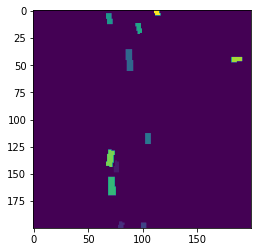

disp shape:  torch.Size([1, 2, 200, 200])
disp shape:  (2, 200, 200)


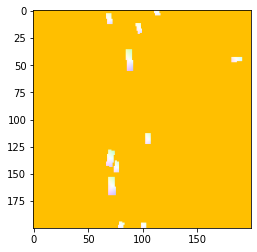

In [5]:
from cross_view_transformer.utils.instance import predict_instance_segmentation_and_trajectories

def colorize_displacement(disp, if_scale=False):

    if if_scale:
        pos = np.where(disp < 254)
        disp[pos] = disp[pos] * 5 * 2


    import matplotlib.colors
    import math

    a = (np.arctan2(-disp[0], -disp[1]) / math.pi + 1) / 2

    r = np.sqrt(disp[0] ** 2 + disp[1] ** 2)
    s = r / np.max(r)
    hsv_color = np.stack((a, s, np.ones_like(a)), axis=-1)
    rgb_color = matplotlib.colors.hsv_to_rgb(hsv_color)

    import matplotlib.pylab as plt
    plt.imshow(rgb_color)
    plt.show()

    return rgb_color

jump_flag = 1

import matplotlib
with torch.no_grad():
    for batch in loader:
        
        jump_flag -= 1
        if jump_flag != 0:
            continue
        
        batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
        # batch keys
        print('batch keys: ', batch.keys())
        print('center shape: ', batch['center'].shape)
        print('instance shape: ', batch['instance_bev'].shape)
        print('instance unique: ', torch.unique(batch['instance_bev']))
        import matplotlib.pylab as plt
        plt.imshow(batch['instance_bev'][0, 0, :, :].cpu())
        plt.show()
        print('disp shape: ', batch['offset_bev'].shape)
        
        
        disp = batch['offset_bev'].squeeze(0).cpu().numpy()
        print('disp shape: ', disp.shape)
        
        disp_color = colorize_displacement(disp, if_scale=True)
        
#         matplotlib.pyplot.figure(figsize=(90, 25))
#         matplotlib.pyplot.imshow(pred['center'].squeeze(0).squeeze(0).cpu())
#         matplotlib.pyplot.show()
#         matplotlib.pyplot.imshow(pred_consistent_instance_seg.squeeze(0).squeeze(0).cpu())
#         matplotlib.pyplot.show()
        
        break

# end the debug
# import sys; sys.exit()

# test center process

batch keys:  dict_keys(['cam_idx', 'image', 'intrinsics', 'extrinsics', 'bev', 'view', 'visibility', 'center', 'pose', 'instance_bev', 'offset_bev'])
ground_truth shape:  torch.Size([1, 200, 200])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')
pred shape:  torch.Size([1, 1, 1, 200, 200])
center shape:  torch.Size([1, 1, 200, 200])
center unique:  <bound method Tensor.unique of tensor([[[[9.3186e-03, 7.8810e-03, 7.5694e-03,  ..., 1.3729e-03,
           1.8114e-03, 3.7822e-03],
          [6.7294e-03, 5.2592e-03, 4.7385e-03,  ..., 9.1085e-05,
           1.9287e-04, 6.0437e-04],
          [6.8046e-03, 5.5018e-03, 4.8871e-03,  ..., 3.8622e-05,
           8.5458e-05, 2.8774e-04],
          ...,
          [2.6951e-03, 2.0175e-03, 1.8153e-03,  ..., 9.5930e-03,
     

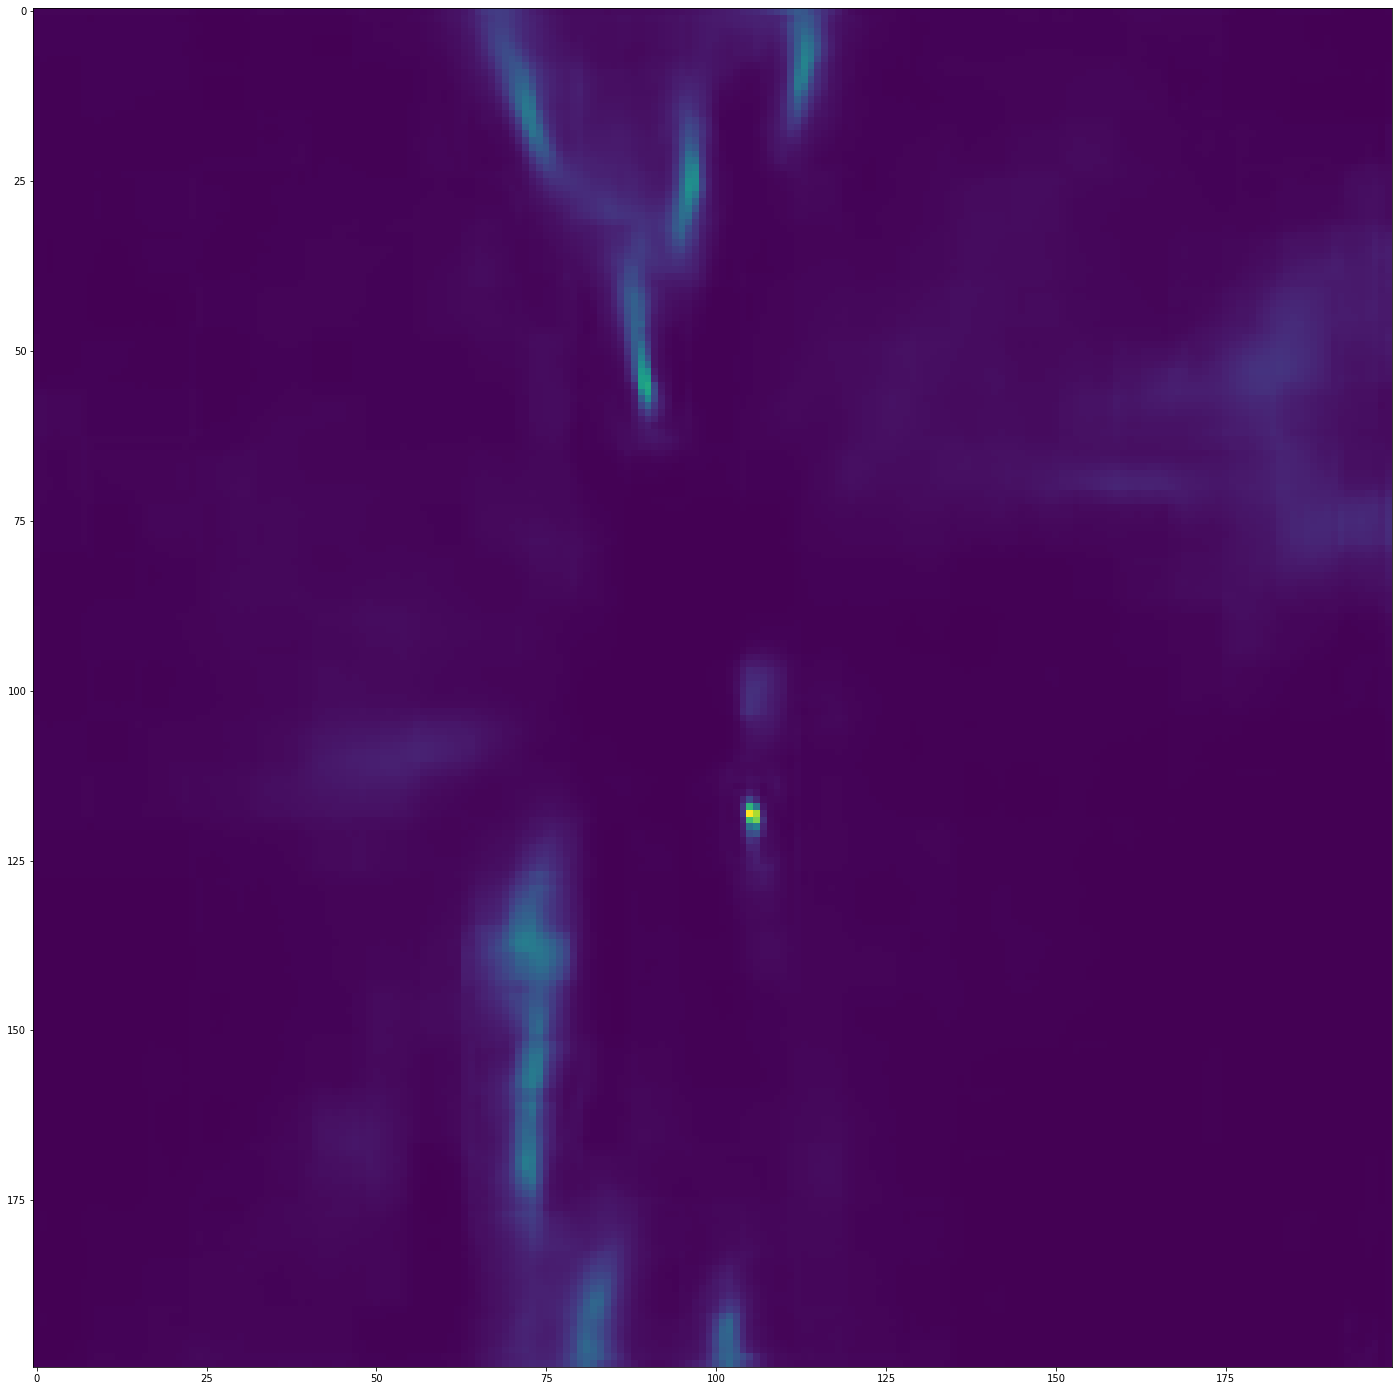

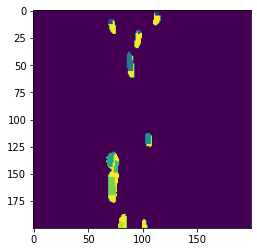

instance bev pred shape:  torch.Size([1, 1, 200, 200])
instance bev pred type:  torch.int64
instance bev gt shape: torch.Size([1, 1, 200, 200])
instance bev gt type:  torch.float32
instance_bev_unique before turn:  tensor([0.0000, 0.0039, 0.0078, 0.0118, 0.0196, 0.0235, 0.0314, 0.0353, 0.0392,
        0.0471, 0.0510, 0.0588], device='cuda:0')
instance_bev_unique after turn:  tensor([0.0000, 0.0039, 0.0078, 0.0118, 0.0196, 0.0235, 0.0314, 0.0353, 0.0392,
        0.0471, 0.0510, 0.0588], device='cuda:0')
ins_gt_int unique:  tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], device='cuda:0')
prediction torch.Size([40000])
pred_to_cls torch.Size([13])
iou:  torch.Size([13, 13])
tp:  tensor([1., 7.])
fp:  tensor([0., 3.])
fn:  tensor([0., 4.])
instance scores:  {'pq': tensor([0.9836, 0.5953]), 'sq': tensor([0.9836, 0.8929]), 'rq': tensor([1.0000, 0.6667]), 'denominator': tensor([ 1.0000, 10.5000])}
instance metric iou:  tensor([0.9836, 6.2501])


SystemExit: 

In [8]:
from cross_view_transformer.utils.instance import predict_instance_segmentation_and_trajectories

jump_flag = 1

import matplotlib
with torch.no_grad():
    for batch in loader:
        jump_flag -= 1
        if jump_flag != 0:
            continue
        batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
        
        # batch keys
        print('batch keys: ', batch.keys())
        
        pred = network(batch)
        
        # center scale
        
        # version: 1
        # pos = torch.where(pred['center'] > 0)
        # pred['center'][pos] *= 10
        # print("postive center: ", pred['center'][pos].unique())
        
        # version: 2
        pred['center'] = torch.sigmoid(pred['center'])
        
        # version: 3
#         pred['center'] = batch['center']
        
        
        # for center process preprocess
        n, c, h, w = pred['bev'].shape
        
        ground_truth = batch['bev'][:, 4:8,:,:].sum(1, keepdim=False)
        
        print('ground_truth shape: ', ground_truth.shape)
        print(ground_truth)
        
#         pred['segmentation'] = ground_truth.unsqueeze(1).cpu() * 0.6
#         pred['segmentation'] = pred['bev'].unsqueeze(1).cpu()
        # sigmoid bev version
        pred['segmentation'] = torch.sigmoid(pred['bev'].unsqueeze(1).cpu())

        print('pred shape: ', pred['segmentation'].shape)
        pred['instance_center'] = pred['center'].unsqueeze(1).cpu()
        # pred['instance_offset'] = torch.zeros([n, 1, 2, h, w])
        pred['instance_offset'] = batch['offset_bev'].unsqueeze(0).cpu()
        
        print('center shape: ', pred['center'].shape)
        print('center unique: ', pred['center'].unique)
        print(pred['instance_offset'].shape)
        
        
        pred['instance_flow'] = None
        thresh = 0.4 * torch.ones_like(pred['segmentation'], device=pred['segmentation'].device)
        pred['segmentation'] = torch.cat((thresh, pred['segmentation']), 2)
        # center generation
        pred_consistent_instance_seg = predict_instance_segmentation_and_trajectories(
                pred, compute_matched_centers=False, make_consistent=True
            )
        
        print('instance seg len: ', len(pred_consistent_instance_seg))
#         import sys; sys.exit()
        print('instance seg shape: ', pred_consistent_instance_seg.shape)
        
        ins_np = pred_consistent_instance_seg.numpy()
        print('ins np unique: ', np.unique(ins_np))
        
#         pos = np.where(ins_np != 0)
#         print('ins np non-zero location: ', pos)
        
        # contents in pred
        print(pred.keys())
        print(pred['bev'].shape)

        visualization = np.vstack(viz(batch=batch, pred=pred))
        
        # show details of pred['center']
        # visualization = pred['center'].cpu()

        # print origin gt
        # visualization = np.vstack(viz(batch=batch))

        images.append(visualization)
        
        # get cropped shape
        visualization = visualization[:, -200:, :]
        print(visualization.shape)
        
        # get np version
        v_np = visualization
        print('max: ', v_np.max())
        print('min: ', v_np.min())
        print('unique: ', np.unique(v_np))
        

        matplotlib.pyplot.figure(figsize=(90, 25))
#         matplotlib.pyplot.imshow(visualization)
        matplotlib.pyplot.imshow(pred['center'].squeeze(0).squeeze(0).cpu())
        matplotlib.pyplot.show()
        matplotlib.pyplot.imshow(pred_consistent_instance_seg.squeeze(0).squeeze(0).cpu())
        matplotlib.pyplot.show()
        
        # test metric
#         !pip list
#         from pytorch_lightning.metrics.metric import Metric
#         from torchmetrics import Metric
#         from torchmetrics.classification import stat_scores_multiple_classes
#         from pytorch_lightning.metrics.functional.reduction import reduce

        # test video format input
#         pred_consistent_instance_seg = pred_consistent_instance_seg.unsqueeze(0)
#         batch['instance_bev'] = batch['instance_bev'].unsqueeze(0)

        from cross_view_transformer.metrics import PanopticMetric
        metric_panoptic_val = PanopticMetric(n_classes=2)
        print("instance bev pred shape: ", pred_consistent_instance_seg.shape)
        print("instance bev pred type: ", pred_consistent_instance_seg.dtype)
        print("instance bev gt shape:", batch['instance_bev'].shape)
        print("instance bev gt type: ", batch['instance_bev'].dtype)
        
        print("instance_bev_unique before turn: ", torch.unique(batch['instance_bev']))
#         batch['instance_bev'] = batch['instance_bev'].type_as(pred_consistent_instance_seg)
        print("instance_bev_unique after turn: ", torch.unique(batch['instance_bev']))
        
        # save result for test
        import numpy as np
        np.save('./pred.npy', pred_consistent_instance_seg.cpu().numpy())
        np.save('./gt.npy', batch['instance_bev'].cpu().numpy())
        
        # instance gt process
        ins_gt = batch['instance_bev']
        ins_gt_unique = torch.unique(batch['instance_bev'])
        ins_gt_int = torch.zeros_like(batch['instance_bev'], dtype=torch.int64)
        for i in range(len(ins_gt_unique)):
            pos = torch.where(ins_gt == ins_gt_unique[i])
            ins_gt_int[pos] = i
        
        print('ins_gt_int unique: ', torch.unique(ins_gt_int))
        metric_panoptic_val(pred_consistent_instance_seg.cpu(), ins_gt_int.cpu())
        # gt test
#         metric_panoptic_val(ins_gt_int.cpu(), ins_gt_int.cpu())    
    
        scores = metric_panoptic_val.compute()
        print("instance scores: ", scores)
        
#         print("instance metric res: ", res)
        
        print("instance metric iou: ", metric_panoptic_val.iou)
        
        break

# end the debug
import sys; sys.exit()

# test my visualize

In [ ]:
import matplotlib
with torch.no_grad():
    for batch in loader:
        batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
        pred = network(batch)
        
        # contents in pred
        print(pred.keys())
        print(pred['bev'].shape)

        visualization = np.vstack(viz(batch=batch, pred=pred))

        # print origin gt
        # visualization = np.vstack(viz(batch=batch))

        images.append(visualization)
        
        # get cropped shape
        visualization = visualization[:, -200:, :]
        print(visualization.shape)
        
        # get np version
        v_np = visualization
        print('max: ', v_np.max())
        print('min: ', v_np.min())
        print('unique: ', np.unique(v_np))
        

        matplotlib.pyplot.figure(figsize=(90, 25))
        matplotlib.pyplot.imshow(visualization)
        matplotlib.pyplot.imshow(pred['center'].squeeze(0).squeeze(0).cpu())
        matplotlib.pyplot.show()
        
        break


# Origin Gif Generation

In [ ]:

with torch.no_grad():
    for batch in loader:
        batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
        pred = network(batch)

        visualization = np.vstack(viz(batch=batch, pred=pred))

        images.append(visualization)
        
        break


print("ready to save...")
# Save a gif
duration = [1 for _ in images[:-1]] + [5 for _ in images[-1:]]
imageio.mimsave(GIF_PATH, images, duration=duration)

html = f'''
<div align="center">
<img src="{GIF_PATH}?modified={time.time()}" width="80%">
</div>
'''

display(widgets.HTML(html))

# BEV 问题 08.15
* center中点不为1
* 没有instance seg 的标注
* 没有instance bbox 的标注

# cvt instance seg baseline
* step1：prediction
    * 语义分割
    * 中心点分割
    * offset回归
* step2：post process
    * center point threshold & maxpooling
    * group center location & assign